Author: Ramin Farhanian

# Abstraction
Mondelēz International, Inc., is an American multinational confectionery, food, and beverage company based in Illinois which employs about 107,000 people around the world. It consists of the global snack and food brands of the former Kraft Foods Inc. after the October 2012 spin-off of its North American grocery operations. The Mondelez name, adopted in 2012, was suggested by Kraft Foods employees and is derived from the Latin word mundus ("world") and delez, a fanciful modification of the word "delicious". We would like to analyze their stocks and find a model(using ARIMA model) that can explain the stock changes using 854 available records.


# Introduction
Following is the plot of our data. We would like to use ARIMA to find a model that explains and predicts the stock changes in time. In order to do that, we initially do some test to verify if our data meets the ARIMA assumptions and then using Intuition technique, we will guess the Paritial Autocorrelation(p), Integrated Part(d) and Moving Arverage Part(q). Then we will use a brute force technique to find the best possible values and will discuss which one we will pick. 

In [31]:
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as web
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2019, 2, 1)
price = web.DataReader('MDLZ', 'yahoo', start, end)
price.index = pd.to_datetime(price.index)

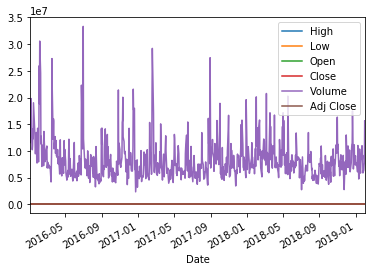

In [32]:
price.plot()

ARIMA models should meet the following requirements:
  * It should be linear.
  * The series must be stationary. There should be no trend in the data.
  * There should be no seasonal pattern.
  
The plot does not indicate an obvious seasonal pattern. However, we need to run Dickey-Fuller test to verify if the data is meets the ARMIA model requirements. Following method is the Dickey-Fuller test:

In [33]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(2).mean()
    rolstd = timeseries.rolling(2).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)



## Dickey-Fuller test

Following is the result of Dickey-Fuller test. The test statistic value(-2.929182) is less than 95 percentile. I can say with 95 percent confidence that this data is stationary so It is safe to use ARIMA. The lags used is 5 (changing rolling statistics did not have any impact on it) and it might not be large enough for 854 records used in this analysis but we are going to use ARIMA anyway and find p, d and q.

I tested the stocks of so many different companies. It was very hard to find a model that meets the ARIMA requirements (even with shifting technique). The range of our data is not ideal but it meets the ARIMA assumptions.

In [34]:
#test_stationarity(price)

In [35]:
from statsmodels.tsa.stattools import acf,pacf
acf_plot = acf(diff.dropna(), nlags= 20)
#Plot ACF:
plt.figure(figsize=(20, 4))

plt.subplot(121)
plt.plot(acf_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_plot)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_plot)), linestyle='--', color='gray')
for i in range (1, 20):
    plt.axvline(x=i, linestyle=":", color="gray")
plt.title('Autocorrelation Function')


NameError: name 'diff' is not defined

## D value analysis
After running the above code, we observe that there are more than 10 lags, the autocorrelation function drastically drops bellow upper control limit to less than zero. This indicates that, according to rule No. 2 "d" should be zero.

In [ ]:
pacf_plot = pacf(diff, nlags=20)
#Plot ACF:
plt.figure(figsize=(20, 4))

plt.subplot(121)
plt.plot(pacf_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_plot)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_plot)), linestyle='--', color='gray')
for i in range (1, 20):
    plt.axvline(x=i, linestyle=":", color="gray")
plt.title('Partial Autocorrelation Function')

## P and Q value Analysis
The Partial Autocorrelation Function has a sharp drastic cutoff and becomes negative at 1. That is why rule 7 will be applied and we consider adding 1 to MA(q) and AR(P) will become zero. 

## Fitting the model
 The model is displayed at the following. The density diagram illustrates a Gaussian distribution. This seems to be a good model. 

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model = ARIMA(diff, order=(0,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Brute Force
 Following code fits the model with all possible p, d and q values and plots them against the existing data. It also prints the loss function output per model.
 
## Output
  According to the following code, the best model is the model with p=3, d=0 and q=2. The loss function that explains the SSE is 15.34505. This is different than what we chose using intuition method (p=0, d=0, q=1). 

In [ ]:
import numpy as np
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(diff, order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(diff)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(diff)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

In [ ]:
loss_best


In [ ]:
best_ints


## Conclusion
 When I compare the intuition model (0,0,1) vs. the best brute force model(3,0,2), I observe that the value of the loss function using the intuition model is 15.4548 which is a bit larger than the best model(15.34), so the intuition model does not explain the data as good as the brute force model. Both models are not visually that different but considering that the model with a lower loss function value explains the data better, I choose the brute force best solution which is (3, 0, 2) which is described at the following.  

In [ ]:
bestModel = ARIMA(diff, order=(3,0,2))
best_model_fit = bestModel.fit(disp=0)
print(best_model_fit.summary())
# plot residual errors
best_model_residuals = pd.DataFrame(model_fit.resid)
best_model_residuals.plot()
plt.show()
best_model_residuals.plot(kind='kde')
plt.show()
print(best_model_residuals.describe())

## Reference 
 The live session videos